# Age Estimation and Gender Classification

In this assignment, you will train CNN models to estimate a person's age and gender by given a face image. Please read carefully all the instructions before you start to write your code.

**Your tasks**

You need train two CNN models:
- one is defined by you with a few restrictions and be trained from scratch, save it as `age_gender_A.h5`
- the other is to finetune a pretrained model, save it as `age_gender_B.h5`

**Dataset**

Your models will be trained and validated on a folder `train_val/` containing 5,000 labeled face images (size: 128 x 128), originated from the UTKFace dataset. During marking, your code will be tested on unseen test data. 

**Performance metric**

The metrics for measuring the performance on the test set are:
- age estimation: MAE (Mean Absolute Error)
- gender classification: accuracy

**Please use the GPU time wisely.**

Just be aware that there is some limit of free GPU usage (It is said the users can use up to 12 hours in row. But many people found they reached its limit far less than 12 hours.). Therefore, I would give you three suggestions to mimimise the risk of reaching the limit.

1. Make sure you have a stable internet connection.
2. Double check all the hyperparameters are good before you start to train the model.
3. According to my experience, each model should be trained in less than 2 hours. If much longer than that, you'd better consider adjusting the architecture.

In [1]:
import tensorflow as tf
import numpy as np
import tensorflow.keras as keras
import cv2
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from os import listdir
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers

image_width = image_height = 128
image_channels = 3 # RGB
data_frame_labels = ['Age', 'Gender', 'Filenames']

## Setting Up: Mount the google drive
Mount your google drive to the notebook. 

Also don't forget to **enable GPU** before your training.


In [2]:
#
# Add your code here
#
from google.colab import drive
drive.mount('/content/drive', force_remount = True)
content_dir = "/content/drive/MyDrive/ML2CW1/"

# Load data locally
# content_dir = '/mnt/g/My Drive/'

ModuleNotFoundError: No module named 'google.colab'

In [4]:
content_dir = "/home/daniel/ML1Labs/ML2/CW1/"
image_dir = content_dir + "train_val/"
file_names = listdir(image_dir)

image_paths = list(map(lambda x : image_dir + x, file_names))

labels = []
for name in file_names:
  label = name.split("_")[:2]
  labels.append(label)

## Visualize a few photos
It is always benificial to know your data well before you start. Here display a few (at least 20) images together with its corresponding age and gender from the `train_val/` folder to have a first impression of the dataset. You may also check what the size of the images are.

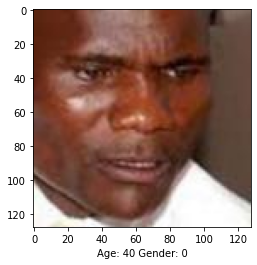

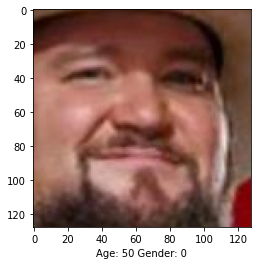

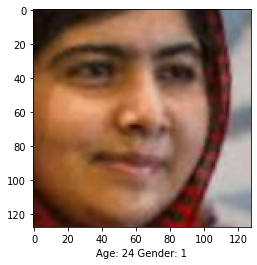

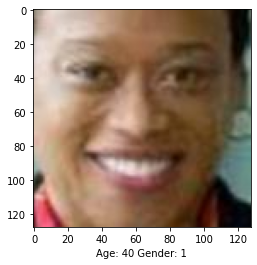

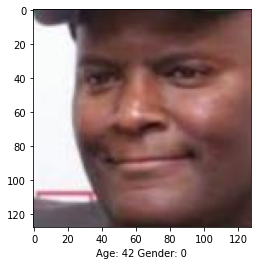

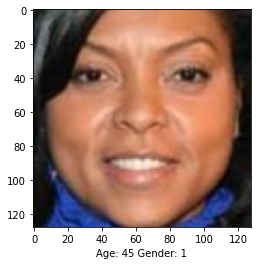

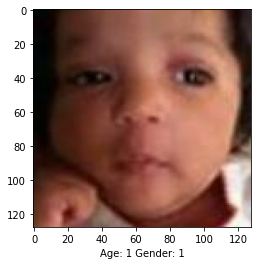

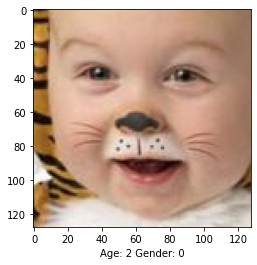

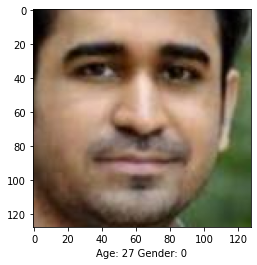

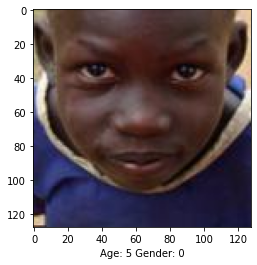

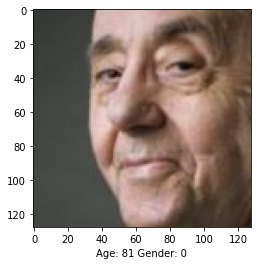

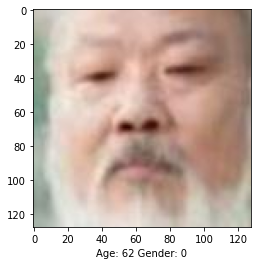

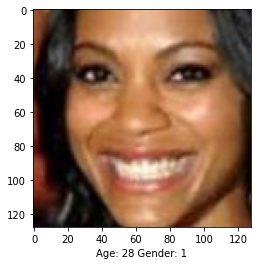

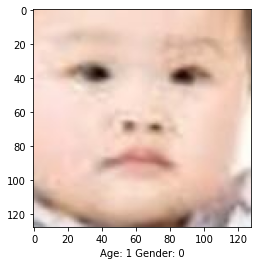

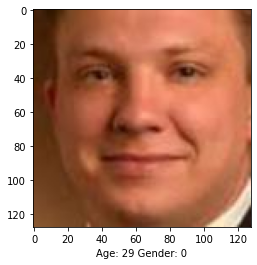

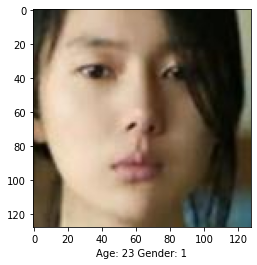

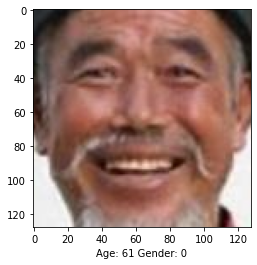

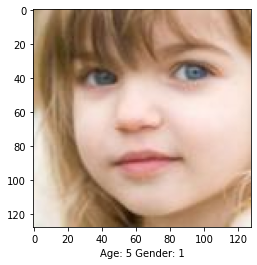

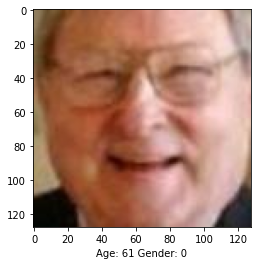

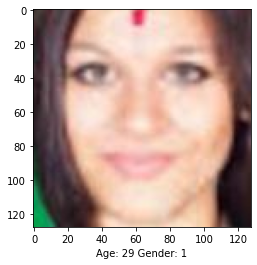

In [5]:
imgs_to_show = []
num_images = 20

random_image_paths = random.sample(image_paths, num_images)

for i in range(num_images):
  imgs_to_show.append(mpimg.imread(random_image_paths[i]))

axes=[]

for i in range(20):
  image = imgs_to_show[i]
  label = random_image_paths[i].split("/")[-1].split("_")[:2]
  fig = plt.figure()
  plt.xlabel("Age: " + label[0] + " Gender: " + label[1])
  plt.imshow(image)

plt.show()

## Rearrange the dataset
You may do any arrangement for the dataset to suit your later process, such as splitting into training set and validation set, saving the gender labels and age some how, and so on.


In [7]:
#
# Add your code here
#
import pandas as pd

records = []
for l_age, l_gender in labels:
  records.append((int(l_age), int(l_gender)))
df = pd.DataFrame(records)
df[data_frame_labels[-1]] = image_paths
df.columns = data_frame_labels

## STEP1: Data pre-processing
Now you need do some pre-processing before feeding data into a CNN network. You may consider:

1.	Rescale the pixel values (integers between 0 and 255) to [0,1]. **You must do this rescaling.** Otherwise the testing performance will be affected significantly, as the test images will be rescaling in this way. 
2.	Data augmentation.

**Don't rescale the age to [0,1].** Otherwise the testing performance will be affected significantly, as the original age is used in the testing stage. 

In [8]:
#
# Add your code here
#

image_datagen = ImageDataGenerator(rescale=1./255, rotation_range=20, zoom_range=0.1, horizontal_flip=True, validation_split = 0.2)
train_generator = image_datagen.flow_from_dataframe(df, x_col=data_frame_labels[-1], y_col=data_frame_labels[:-1], target_size=(image_width,image_height), color_mode='rgb', class_mode='multi_output', subset='training', batch_size=32)
validation_generator = image_datagen.flow_from_dataframe(df, x_col=data_frame_labels[-1], y_col=data_frame_labels[:-1], target_size=(image_width,image_height), color_mode='rgb', class_mode='multi_output', subset='validation', batch_size=32)


Found 4000 validated image filenames.
Found 1000 validated image filenames.


## STEP2A: Build your own CNN network
Define your own CNN for classifying the gender and predicting the age. Though there are two tasks, you need **only one CNN model, but with two outputs** - you may search online for solution.

There are a few restrictions about your network as follows.
1.	The input size must be 128 x 128 x 3, which means you **should not resize** the original images. This is because my test code relies on this particular input size. Any other size will cause problem in the testing stage.
2.  Please treat the gender classification as a binary problem, i.e., **the output layer for the gender branch has only 1 unit**, instead of 2 (though it is correct to treat the gender classification as a mutli-class problem where class number is 2, the last layer has 2 units). This is because my test code only works for the 1-unit-last-layer gender branch setting. 
3.	The size of feature maps being fed to the first fully connected layer must be less than 10 x 10, while there is no number limitation about the depth.
4.	You may choose any techniques for preventing overfitting. 

In the end of the cell, use `modelA.summary()` to output the model architecture. You may also use `plot_model()` to visualize its architecture.

In [34]:
#
# Add your code here
#

######################################################
##                                                  ##
##    Model Creation With Tuned Hyper-Parameters    ##
##                                                  ##
######################################################

def create_modelA():
  inputs = keras.Input((image_width, image_height, image_channels))
  common_layers = create_modelA_common_layers(inputs)
  
  gender_branch = create_gender_branch(common_layers)
  age_branch = create_age_branch(common_layers)

  # Creating 1 model w/ two branches per https://pyimagesearch.com/2018/06/04/keras-multiple-outputs-and-multiple-losses/
  return keras.Model(inputs=inputs, outputs=[age_branch, gender_branch], name="ModelA")

def create_modelA_common_layers(inputs):
    common_layers = layers.Conv2D(64, (3, 3), activation='relu')(inputs)
    common_layers = layers.Conv2D(64, (3, 3), activation='relu')(common_layers)
    common_layers = layers.MaxPooling2D((2,2))(common_layers)
    common_layers = layers.BatchNormalization(axis = 3)(common_layers)
  
    common_layers = layers.Conv2D(128, (3, 3), activation='relu')(common_layers)
    common_layers = layers.MaxPooling2D((2,2))(common_layers)

    return common_layers

def create_gender_branch(inputs):    
    gender_branch = layers.Conv2D(64, (3, 3), activation='relu')(inputs)
    gender_branch = layers.MaxPooling2D((2,2))(gender_branch)
    gender_branch = layers.BatchNormalization()(gender_branch)
    
    gender_branch = layers.Conv2D(128, (2, 2), activation='relu')(gender_branch)
    gender_branch = layers.MaxPooling2D((2,2))(gender_branch)
    gender_branch = layers.BatchNormalization()(gender_branch)

    gender_branch = layers.Conv2D(64, (2, 2), activation='relu')(gender_branch) # depth determined by hyper-param-tuning # hp.Choice('gender_cnn_feature_depth', values=[1, 32, 64, 128])
    gender_branch = layers.Flatten()(gender_branch)

    gender_dropout = 0.2 # dropout rate determined by hyper-param-tuning # hp.Choice('gender_dropout_rate', values=[5e-2, 1e-1, 2e-1])
    gender_regularisation = 0.01 # regularisation factor determined by hyper-param-tuning # hp.Choice('gender_regularisation', values=[1e-2, 2e-2, 5e-2])
    
    gender_branch = layers.Dropout(gender_dropout)(gender_branch)
    gender_branch = layers.Dense(128, activation='relu', activity_regularizer=tf.keras.regularizers.l2(gender_regularisation))(gender_branch)
    gender_branch = layers.Dropout(gender_dropout)(gender_branch)
    gender_branch = layers.Dense(16, activation='relu', activity_regularizer=tf.keras.regularizers.l2(gender_regularisation))(gender_branch)
    gender_branch = layers.Dropout(gender_dropout)(gender_branch)

    gender_branch = layers.Dense(1, activation='sigmoid', activity_regularizer=tf.keras.regularizers.l2(gender_regularisation), name='gender_output')(gender_branch)

    return gender_branch

def create_age_branch(inputs):
    age_branch = layers.Conv2D(64, (3, 3), activation='relu')(inputs)
    age_branch = layers.MaxPooling2D((2,2))(age_branch)
    age_branch = layers.BatchNormalization(axis = 3)(age_branch)
    
    age_branch = layers.Conv2D(128, (2, 2), activation='relu')(age_branch)
    age_branch = layers.MaxPooling2D((2,2))(age_branch)
    age_branch = layers.BatchNormalization(axis = 3)(age_branch)
    
    age_branch = layers.Conv2D(128, (2, 2), activation='relu')(age_branch) # depth determined by hyper-param-tuning # hp.Choice('age_cnn_feature_depth', values=[1, 32, 64, 128])
    age_branch = layers.Flatten()(age_branch)
    
    age_dropout = 0.05 # dropout rate determined by hyper-param-tuning # hp.Choice('age_dropout_rate', values=[5e-2, 1e-1, 2e-1])
    age_regularisation = 0.01 # regularisation factor determined by hyper-param-tuning # hp.Choice('age_regularisation', values=[1e-2, 2e-2, 5e-2])

    age_branch = layers.Dropout(age_dropout)(age_branch)
    age_branch = layers.Dense(128, activation='relu', activity_regularizer=tf.keras.regularizers.l2(age_regularisation))(age_branch)
    age_branch = layers.Dropout(age_dropout)(age_branch)
    age_branch = layers.Dense(16, activation='relu', activity_regularizer=tf.keras.regularizers.l2(age_regularisation))(age_branch)
    age_branch = layers.Dropout(age_dropout)(age_branch)
    
    age_branch = layers.Dense(1, activation='relu',activity_regularizer=tf.keras.regularizers.l2(age_regularisation), name='age_output')(age_branch)

    return age_branch

modelA = create_modelA()

modelA.summary()
from keras.utils.vis_utils import plot_model
plot_model(modelA, show_shapes=True)


######################################
##                                  ##
##   Hyper-Parameter Tuning Logic   ##
##    Kept for reference but no     ##
##    longer needed to build the    ##
##               model              ##
##                                  ##
######################################

# !pip install -q -U keras-tuner
#
# import keras_tuner as kt
#
# def modelA_builder(hp: kt.HyperParameters):
#   gender_sigmoid = hp.Boolean('gender_sigmoid')
#   def create_modelA(hp: kt.HyperParameters):
#     greyscale = hp.Choice('use_greyscale', values=[0,1,2]) # 0 - no grescale, 
#     inputs = keras.Input((image_width, image_height, image_channels))
#
#     if (greyscale == 2): # only apply greyscale to gender branch 
#       gender_inputs = layers.Lambda(lambda c: tf.image.rgb_to_grayscale(c))(inputs)
#       gender_branch = create_modelA_common_layers(gender_inputs)
#       gender_branch = create_gender_branch(gender_branch, hp)
#
#       age_branch = create_modelA_common_layers(inputs)
#       age_branch = create_age_branch(age_branch, hp)
#     else: # greyscale for both or neither branch
#       greyscale_layer = layers.Lambda(lambda c: tf.image.rgb_to_grayscale(c))(inputs) if greyscale == 1 else inputs
#       common_layers = create_modelA_common_layers(greyscale_layer)
#       gender_branch = create_gender_branch(common_layers, hp)
#       age_branch = create_age_branch(common_layers, hp)
#
#     # Creating 1 model w/ two branches per https://pyimagesearch.com/2018/06/04/keras-multiple-outputs-and-multiple-losses/
#     return keras.Model(inputs=inputs, outputs=[age_branch, gender_branch], name="ModelA")
#
#   def create_modelA_common_layers(inputs):
#       common_layers = layers.Conv2D(64, (3, 3), activation='relu')(inputs) # 124, 124, 512
#       common_layers = layers.Conv2D(64, (3, 3), activation='relu')(common_layers)
#       common_layers = layers.MaxPooling2D((2,2))(common_layers) # 50, 50, 1024
#       common_layers = layers.BatchNormalization(axis = 3)(common_layers)
#     
#       common_layers = layers.Conv2D(128, (3, 3), activation='relu')(common_layers) # 124, 124, 512
#       common_layers = layers.MaxPooling2D((2,2))(common_layers) # 50, 50, 1024
#
#       return common_layers
#
#   def create_gender_branch(inputs, hp: kt.HyperParameters):    
#       gender_branch = layers.Conv2D(64, (3, 3), activation='relu')(inputs)
#       gender_branch = layers.MaxPooling2D((2,2))(gender_branch) # 50, 50, 1024
#       gender_branch = layers.BatchNormalization()(gender_branch)
#      
#       gender_branch = layers.Conv2D(128, (2, 2), activation='relu')(gender_branch)
#       gender_branch = layers.MaxPooling2D((2,2))(gender_branch) # 50, 50, 1024
#       gender_branch = layers.BatchNormalization()(gender_branch)
#
#       gender_branch = layers.Conv2D(hp.Choice('gender_cnn_feature_depth', values=[1, 32, 64, 128]), (2, 2), activation='relu')(gender_branch)
#       gender_branch = layers.Flatten()(gender_branch)
#
#       gender_dropout = hp.Choice('gender_dropout_rate', values=[5e-2, 1e-1, 2e-1])
#       gender_regularisation = hp.Choice('gender_regularisation', values=[1e-2, 2e-2, 5e-2])
#      
#       gender_branch = layers.Dropout(gender_dropout)(gender_branch)
#       gender_branch = layers.Dense(128, activation='relu', activity_regularizer=tf.keras.regularizers.l2(gender_regularisation))(gender_branch)
#       gender_branch = layers.Dropout(gender_dropout)(gender_branch)
#       gender_branch = layers.Dense(16, activation='relu', activity_regularizer=tf.keras.regularizers.l2(gender_regularisation))(gender_branch)
#       gender_branch = layers.Dropout(gender_dropout)(gender_branch)
#
#       if gender_sigmoid:
#         gender_branch = layers.Dense(1, activation='sigmoid', name='gender_output')(gender_branch)
#       else:
#         gender_branch = layers.Dense(1, name='gender_output')(gender_branch)
#
#       return gender_branch
#
#   def create_age_branch(inputs, hp: kt.HyperParameters):
#       age_branch = layers.Conv2D(64, (3, 3), activation='relu')(inputs)
#       #age_branch = layers.Flatten()(age_branch)
#      
#       #age_branch = layers.Conv2D(64, (3, 3), activation='relu')(age_branch)
#       age_branch = layers.MaxPooling2D((2,2))(age_branch) # 50, 50, 1024
#       age_branch = layers.BatchNormalization(axis = 3)(age_branch)
#       #age_branch = layers.Flatten()(age_branch)
#     
#       age_branch = layers.Conv2D(128, (2, 2), activation='relu')(age_branch)
#       age_branch = layers.MaxPooling2D((2,2))(age_branch) # 50, 50, 1024
#       age_branch = layers.BatchNormalization(axis = 3)(age_branch)
#       # age_branch = layers.Flatten()(age_branch)
#     
#       age_branch = layers.Conv2D(hp.Choice('age_cnn_feature_depth', values=[1, 32, 64, 128]), (2, 2), activation='relu')(age_branch)
#       age_branch = layers.Flatten()(age_branch)
#   
#       age_dropout = hp.Choice('age_dropout_rate', values=[5e-2, 1e-1, 2e-1])
#       age_regularisation = hp.Choice('age_regularisation', values=[1e-2, 2e-2, 5e-2])
#
#       age_branch = layers.Dropout(age_dropout)(age_branch)
#       age_branch = layers.Dense(128, activation='relu', activity_regularizer=tf.keras.regularizers.l2(age_regularisation))(age_branch)
#       age_branch = layers.Dropout(age_dropout)(age_branch)
#       age_branch = layers.Dense(16, activation='relu', activity_regularizer=tf.keras.regularizers.l2(age_regularisation))(age_branch)
#       age_branch = layers.Dropout(age_dropout)(age_branch)
#       age_branch = layers.Dense(1, activation='relu', name='age_output')(age_branch)
#
#       return age_branch
#
#   modelA = create_modelA(hp)
#
#   losses = {
#     "age_output": keras.losses.MeanSquaredError(), # Effectively weight the loss such that larger losses are penalised more heavily
#     "gender_output": keras.losses.BinaryCrossentropy(from_logits = not gender_sigmoid)
#   }
#   loss_weight = {
#     "age_output": 1, # since using MSE, will be quite large #hp.Choice('age_loss_weight', values=[0.25, 0.5, 1.]),
#     "gender_output": 100 # since likely between 1-0, scale up to be closer to age_loss #hp.Choice('gender_loss_weight', values=[2., 4., 8.])
#   }
#
#   metrics= {
#     "age_output": keras.metrics.MeanAbsoluteError(),
#     "gender_output": keras.metrics.BinaryAccuracy()
#   }
#
#   lr_schedule = keras.optimizers.schedules.ExponentialDecay(
#       initial_learning_rate=hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4]),
#       decay_steps=train_generator.n*2,
#       decay_rate=0.9)
#
#   # compile model
#   modelA_compiled = modelA.compile(loss=losses, loss_weights = loss_weight, optimizer=keras.optimizers.Adam(learning_rate=lr_schedule), metrics=metrics)
#   return modelA
#
# tuner = kt.Hyperband(modelA_builder,
#                      objective=kt.Objective("val_loss", direction="min"),
#                      max_epochs=10,
#                      factor=3)
#
# tuner.search(
#     x = train_generator,
#     validation_data=validation_generator, 
#     epochs=50
# )
#
# best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]
#
# print("gender_sigmoid: {}, use_greyscale: {}, gender_cnn_feature_depth: {}, gender_dropout_rate: {}, gender_regularisation: {}, age_cnn_feature_depth: {}, age_dropout_rate: {}, age_regularisation: {}, learning_rate: {}".format(best_hps.get('gender_sigmoid'), best_hps.get('use_greyscale'), best_hps.get('gender_cnn_feature_depth'), best_hps.get('gender_dropout_rate'), best_hps.get('gender_regularisation'), best_hps.get('age_cnn_feature_depth'), best_hps.get('age_dropout_rate'), best_hps.get('age_regularisation'), best_hps.get('learning_rate')))
#
# modelA_optimised = tuner.hypermodel.build(best_hps)
# modelA_optimised.summary()
# from keras.utils.vis_utils import plot_model
# plot_model(modelA_optimised, show_shapes=True)
#
# modelA_optimised_epoch_count = 50 # ?
# modelA_optimised_train_steps_per_epoch = train_generator.n // train_generator.batch_size
# modelA_optimised_val_steps_per_epoch = validation_generator.n // validation_generator.batch_size
#
# modelA_optimised.fit(
#     x = train_generator,
#     validation_data=validation_generator,
#     epochs=modelA_optimised_epoch_count,
#     steps_per_epoch=modelA_optimised_train_steps_per_epoch,
#     validation_steps=modelA_optimised_val_steps_per_epoch
# )

Model: "ModelA"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_15 (InputLayer)          [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_18 (Conv2D)             (None, 126, 126, 64  1792        ['input_15[0][0]']               
                                )                                                                 
                                                                                                  
 conv2d_19 (Conv2D)             (None, 124, 124, 64  36928       ['conv2d_18[0][0]']              
                                )                                                            

 age_output (Dense)             (None, 1)            17          ['dropout_57[0][0]']             
                                                                                                  
 gender_output (Dense)          (None, 1)            17          ['dropout_54[0][0]']             
                                                                                                  
Total params: 1,045,058
Trainable params: 1,044,162
Non-trainable params: 896
__________________________________________________________________________________________________
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


## STEP3A: Compile and train your model
Compile and train your model here. 
Save your model by `modelA.save(your_model_folder+"age_gender_A.h5")` after training. 

**DON'T use any other name for your model file.** This is because my test code relies on this particular model name. Any other file name will cause problem in the testing stage.

**Save the model with `save()` instead of `save_weights()`.** This is because I will load the model by 

`modelA = load_model(model_folder+"age_gender_A.h5")`. 


In [35]:
#
# Add your code here
#

losses = {
	"age_output": keras.losses.MeanSquaredError(),
  "gender_output": keras.losses.BinaryCrossentropy()
}
loss_weight = {
	"age_output": 1.0,
    "gender_output": 100.0
}

metrics= {
  "age_output": keras.metrics.MeanAbsoluteError(),
  "gender_output": keras.metrics.BinaryAccuracy()
}

lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.001, # learning rate determined by hyper-param-tuning
    decay_steps=(train_generator.n // train_generator.batch_size) * 2, # decay every 2 epochs
    decay_rate=0.9)

# compile model
modelA_compiled = modelA.compile(loss=losses, loss_weights = loss_weight, optimizer=keras.optimizers.Adam(learning_rate=lr_schedule), metrics=metrics)
print("Compiling Model A")

modelA_epoch_count = 50
modelA_train_steps_per_epoch = train_generator.n // train_generator.batch_size
modelA_val_steps_per_epoch = validation_generator.n // validation_generator.batch_size

print("training steps per epoch: {}\nvalidation steps per epoch: {}".format(modelA_train_steps_per_epoch, modelA_val_steps_per_epoch))

print("Fitting Model A")
modelA_history = modelA.fit(
    x = train_generator,
    validation_data=validation_generator,
    epochs=modelA_epoch_count,
    steps_per_epoch=modelA_train_steps_per_epoch,
    validation_steps=modelA_val_steps_per_epoch
)

modelA.save(content_dir+"age_gender_A.h5")

Compiling Model A
training steps per epoch: 125
validation steps per epoch: 31
Fitting Model A
Epoch 1/50
125/125 [==============================] - 14s 106ms/step - loss: 427.2936 - age_output_loss: 326.8889 - gender_output_loss: 0.6203 - age_output_mean_absolute_error: 13.7703 - gender_output_binary_accuracy: 0.6585 - val_loss: 455.9020 - val_age_output_loss: 351.1259 - val_gender_output_loss: 0.7308 - val_age_output_mean_absolute_error: 14.1537 - val_gender_output_binary_accuracy: 0.5292
Epoch 2/50
125/125 [==============================] - 12s 99ms/step - loss: 314.7116 - age_output_loss: 224.8836 - gender_output_loss: 0.5328 - age_output_mean_absolute_error: 11.4098 - gender_output_binary_accuracy: 0.7385 - val_loss: 1571.1985 - val_age_output_loss: 1368.6307 - val_gender_output_loss: 0.8775 - val_age_output_mean_absolute_error: 32.6749 - val_gender_output_binary_accuracy: 0.5282
Epoch 3/50
125/125 [==============================] - 12s 96ms/step - loss: 282.1073 - age_output_loss

125/125 [==============================] - 12s 96ms/step - loss: 132.5681 - age_output_loss: 80.5255 - gender_output_loss: 0.2447 - age_output_mean_absolute_error: 6.6562 - gender_output_binary_accuracy: 0.8995 - val_loss: 147.2485 - val_age_output_loss: 94.7199 - val_gender_output_loss: 0.2776 - val_age_output_mean_absolute_error: 6.8220 - val_gender_output_binary_accuracy: 0.8760
Epoch 22/50
125/125 [==============================] - 12s 95ms/step - loss: 131.6618 - age_output_loss: 79.9013 - gender_output_loss: 0.2461 - age_output_mean_absolute_error: 6.6286 - gender_output_binary_accuracy: 0.8928 - val_loss: 150.4653 - val_age_output_loss: 103.3608 - val_gender_output_loss: 0.2424 - val_age_output_mean_absolute_error: 7.0691 - val_gender_output_binary_accuracy: 0.8851
Epoch 23/50
125/125 [==============================] - 12s 95ms/step - loss: 128.0806 - age_output_loss: 76.8952 - gender_output_loss: 0.2410 - age_output_mean_absolute_error: 6.5449 - gender_output_binary_accuracy: 0

Epoch 42/50
125/125 [==============================] - 12s 94ms/step - loss: 98.8977 - age_output_loss: 57.2788 - gender_output_loss: 0.1688 - age_output_mean_absolute_error: 5.6396 - gender_output_binary_accuracy: 0.9342 - val_loss: 128.4389 - val_age_output_loss: 81.6267 - val_gender_output_loss: 0.2496 - val_age_output_mean_absolute_error: 6.3641 - val_gender_output_binary_accuracy: 0.8962
Epoch 43/50
125/125 [==============================] - 12s 96ms/step - loss: 96.0912 - age_output_loss: 54.6823 - gender_output_loss: 0.1681 - age_output_mean_absolute_error: 5.5346 - gender_output_binary_accuracy: 0.9325 - val_loss: 136.5025 - val_age_output_loss: 87.9983 - val_gender_output_loss: 0.2479 - val_age_output_mean_absolute_error: 6.7025 - val_gender_output_binary_accuracy: 0.8871
Epoch 44/50
125/125 [==============================] - 12s 96ms/step - loss: 98.6821 - age_output_loss: 57.1973 - gender_output_loss: 0.1701 - age_output_mean_absolute_error: 5.6659 - gender_output_binary_acc

## STEP4A: Draw the learning curves
Draw four figures as follows
1.	The loss of the gender classification over the training and validation set
2.	The accuracy of the gender classification over the training and validation set
3.	The loss of the age estimation over the training and validation set
4.	The MAE of the age estimation over the training and validation set


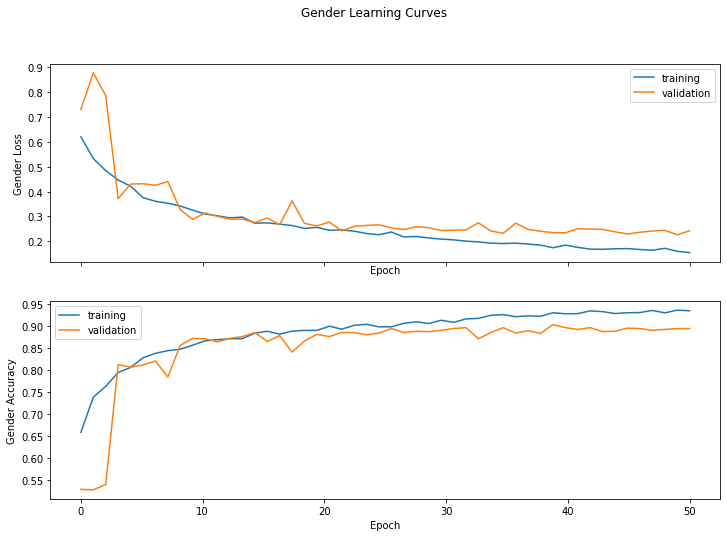

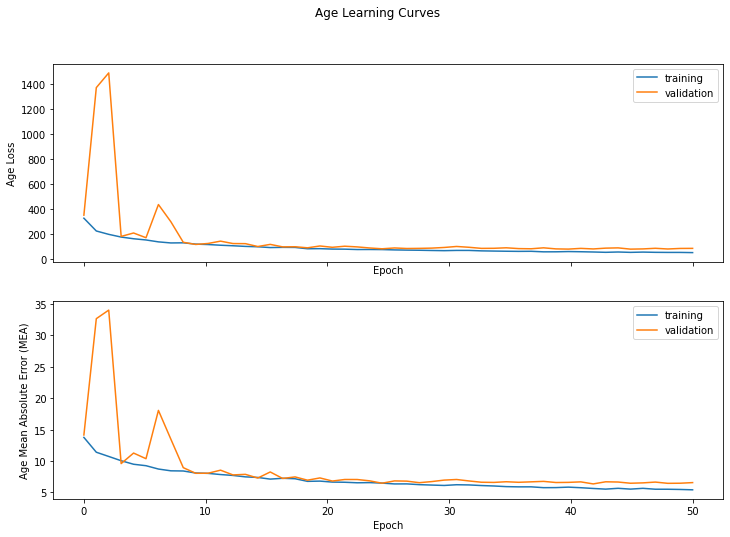

In [36]:
#
# Add your code here
#
epochs = np.linspace(0, modelA_epoch_count, modelA_epoch_count)

fig, (gender_loss, gender_accuracy) = plt.subplots(2, sharex=True)
fig.suptitle("Gender Learning Curves")
fig.set_size_inches(12,8)

gender_loss.set_xlabel("Epoch")
gender_loss.set_ylabel("Gender Loss")
gender_loss.plot(epochs, modelA_history.history['gender_output_loss'], label='training')
gender_loss.plot(epochs, modelA_history.history['val_gender_output_loss'], label='validation')
gender_loss.legend()

gender_accuracy.set_xlabel("Epoch")
gender_accuracy.set_ylabel("Gender Accuracy")
gender_accuracy.plot(epochs, modelA_history.history['gender_output_binary_accuracy'], label='training')
gender_accuracy.plot(epochs, modelA_history.history['val_gender_output_binary_accuracy'], label='validation')
gender_accuracy.legend()

plt.show()

fig, (age_loss, age_mae) = plt.subplots(2, sharex=True)
fig.suptitle("Age Learning Curves")
fig.set_size_inches(12,8)

age_loss.set_xlabel("Epoch")
age_loss.set_ylabel("Age Loss")
age_loss.plot(epochs, modelA_history.history['age_output_loss'], label='training')
age_loss.plot(epochs, modelA_history.history['val_age_output_loss'], label='validation')
age_loss.legend()

age_mae.set_xlabel("Epoch")
age_mae.set_ylabel("Age Mean Absolute Error (MEA)")
age_mae.plot(epochs, modelA_history.history['age_output_mean_absolute_error'], label='training')
age_mae.plot(epochs, modelA_history.history['val_age_output_mean_absolute_error'], label='validation')
age_mae.legend()

plt.show()

## STEP2B: Build a CNN network based on a pre-trained model 
Choose one existing CNN architecture pre-trained on ImageNet, and fine-tune on this dataset.

The same as required in Model A, **don’t resize the input image size**. **The output layer for the gender branch is set to have only 1 unit**. 

In the end of the cell, use `modelB.summary()` to output the model architecture. You may also use `plot_model()` to visualize its architecture.


In [37]:
import tensorflow.keras.applications.resnet50 as ResNet50 # quick, lighweight, and fairly accurate  

inputs_b = keras.Input((image_width, image_height, image_channels))
base_resnet50 = ResNet50.ResNet50(input_tensor=inputs_b, weights='imagenet', include_top=False)
base_resnet50.trainable = True
globalPool = layers.GlobalAveragePooling2D()(base_resnet50.output) # layers.Flatten()(base_resnet50.output)

gender_branch = layers.Dense(256, activation='relu', activity_regularizer=tf.keras.regularizers.l2(0.01))(globalPool)
gender_branch = layers.Dropout(0.2)(gender_branch)
gender_branch = layers.Dense(16, activation='relu', activity_regularizer=tf.keras.regularizers.l2(0.01))(gender_branch)
gender_branch = layers.Dropout(0.2)(gender_branch)
gender_branch = layers.Dense(1, activation = 'sigmoid', activity_regularizer=tf.keras.regularizers.l2(0.01),  name='gender_output')(gender_branch)


age_branch = layers.Dense(256, activation='relu', activity_regularizer=tf.keras.regularizers.l2(0.01))(globalPool)
age_branch = layers.Dropout(0.2)(age_branch)
age_branch = layers.Dense(16, activation='relu', activity_regularizer=tf.keras.regularizers.l2(0.01))(age_branch)
age_branch = layers.Dropout(0.2)(age_branch)
age_branch = layers.Dense(1, name='age_output', activity_regularizer=tf.keras.regularizers.l2(0.01))(age_branch)

modelB = keras.Model(inputs=base_resnet50.inputs, outputs=[age_branch, gender_branch])

modelB.summary()
from tensorflow.keras.utils import plot_model
plot_model(modelB, show_shapes=True)

Model: "model_10"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_16 (InputLayer)          [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 134, 134, 3)  0           ['input_16[0][0]']               
                                                                                                  
 conv1_conv (Conv2D)            (None, 64, 64, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 64, 64, 64)   256         ['conv1_conv[0][0]']      

 conv2_block3_2_conv (Conv2D)   (None, 32, 32, 64)   36928       ['conv2_block3_1_relu[0][0]']    
                                                                                                  
 conv2_block3_2_bn (BatchNormal  (None, 32, 32, 64)  256         ['conv2_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block3_2_relu (Activatio  (None, 32, 32, 64)  0           ['conv2_block3_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block3_3_conv (Conv2D)   (None, 32, 32, 256)  16640       ['conv2_block3_2_relu[0][0]']    
                                                                                                  
 conv2_blo

 conv3_block3_2_conv (Conv2D)   (None, 16, 16, 128)  147584      ['conv3_block3_1_relu[0][0]']    
                                                                                                  
 conv3_block3_2_bn (BatchNormal  (None, 16, 16, 128)  512        ['conv3_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block3_2_relu (Activatio  (None, 16, 16, 128)  0          ['conv3_block3_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block3_3_conv (Conv2D)   (None, 16, 16, 512)  66048       ['conv3_block3_2_relu[0][0]']    
                                                                                                  
 conv3_blo

 conv4_block2_2_conv (Conv2D)   (None, 8, 8, 256)    590080      ['conv4_block2_1_relu[0][0]']    
                                                                                                  
 conv4_block2_2_bn (BatchNormal  (None, 8, 8, 256)   1024        ['conv4_block2_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block2_2_relu (Activatio  (None, 8, 8, 256)   0           ['conv4_block2_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block2_3_conv (Conv2D)   (None, 8, 8, 1024)   263168      ['conv4_block2_2_relu[0][0]']    
                                                                                                  
 conv4_blo

 conv4_block5_2_relu (Activatio  (None, 8, 8, 256)   0           ['conv4_block5_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block5_3_conv (Conv2D)   (None, 8, 8, 1024)   263168      ['conv4_block5_2_relu[0][0]']    
                                                                                                  
 conv4_block5_3_bn (BatchNormal  (None, 8, 8, 1024)  4096        ['conv4_block5_3_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block5_add (Add)         (None, 8, 8, 1024)   0           ['conv4_block4_out[0][0]',       
                                                                  'conv4_block5_3_bn[0][0]']      
          

 conv5_block2_2_relu (Activatio  (None, 4, 4, 512)   0           ['conv5_block2_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv5_block2_3_conv (Conv2D)   (None, 4, 4, 2048)   1050624     ['conv5_block2_2_relu[0][0]']    
                                                                                                  
 conv5_block2_3_bn (BatchNormal  (None, 4, 4, 2048)  8192        ['conv5_block2_3_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block2_add (Add)         (None, 4, 4, 2048)   0           ['conv5_block1_out[0][0]',       
                                                                  'conv5_block2_3_bn[0][0]']      
          

## STEP3B: Compile and train your model
Compile and train your model here. 
Save your model to `age_gender_B.h5` after training. 

**DON'T use any other name for your model file.** This is because my test code relies on this particular model name. Any other file name will cause problem in the testing stage.

**Also, save the model with `save()` instead of `save_weights()`.** 


In [38]:
#
# Add your code here
#
losses = {
  "age_output": keras.losses.MeanSquaredError(),
	"gender_output": keras.losses.BinaryCrossentropy() # BinaryFocalCrossentropy(from_logits = False)
}
loss_weight = {
	"age_output": 1.0,
    "gender_output": 100.0 # 50.0
}
metrics= {
  "age_output": keras.metrics.MeanAbsoluteError(),
  "gender_output": keras.metrics.BinaryAccuracy()
}
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.001, # learning rate determined by hyper-param-tuning
    decay_steps=(train_generator.n // train_generator.batch_size) * 2, # decay every 2 epochs
    decay_rate=0.9)

modelB_compiled = modelB.compile(loss=losses, loss_weights = loss_weight, optimizer=keras.optimizers.Adam(learning_rate=lr_schedule), metrics=metrics)
print("Compiling Model B")

modelB_epoch_count = 50 # ?
modelB_train_steps_per_epoch = train_generator.n // train_generator.batch_size
modelB_val_steps_per_epoch = validation_generator.n // validation_generator.batch_size

early_stop_cb = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=5,
    mode='min', restore_best_weights=True
)

modelB_history = modelB.fit(
    x=train_generator,
    validation_data=validation_generator,
    epochs=modelB_epoch_count,
    steps_per_epoch=modelB_train_steps_per_epoch,
    validation_steps=modelB_val_steps_per_epoch,
    callbacks=[early_stop_cb]
)
modelA.save(content_dir+"age_gender_B.h5")

Compiling Model B
Epoch 1/50
125/125 [==============================] - 23s 148ms/step - loss: 474.6560 - age_output_loss: 360.5115 - gender_output_loss: 0.6119 - age_output_mean_absolute_error: 14.2211 - gender_output_binary_accuracy: 0.6735 - val_loss: 677.7138 - val_age_output_loss: 578.1781 - val_gender_output_loss: 0.8372 - val_age_output_mean_absolute_error: 18.3875 - val_gender_output_binary_accuracy: 0.5272
Epoch 2/50
125/125 [==============================] - 18s 141ms/step - loss: 325.5683 - age_output_loss: 228.6319 - gender_output_loss: 0.4812 - age_output_mean_absolute_error: 11.0893 - gender_output_binary_accuracy: 0.7803 - val_loss: 683.1784 - val_age_output_loss: 600.2086 - val_gender_output_loss: 0.6919 - val_age_output_mean_absolute_error: 18.7756 - val_gender_output_binary_accuracy: 0.5272
Epoch 3/50
125/125 [==============================] - 18s 142ms/step - loss: 290.6384 - age_output_loss: 205.4301 - gender_output_loss: 0.3848 - age_output_mean_absolute_error: 10.

125/125 [==============================] - 18s 143ms/step - loss: 150.5676 - age_output_loss: 106.9524 - gender_output_loss: 0.1590 - age_output_mean_absolute_error: 7.4373 - gender_output_binary_accuracy: 0.9325 - val_loss: 126.5277 - val_age_output_loss: 76.3677 - val_gender_output_loss: 0.2482 - val_age_output_mean_absolute_error: 6.0391 - val_gender_output_binary_accuracy: 0.8911
Epoch 22/50
125/125 [==============================] - 18s 142ms/step - loss: 142.2567 - age_output_loss: 98.4442 - gender_output_loss: 0.1603 - age_output_mean_absolute_error: 7.1909 - gender_output_binary_accuracy: 0.9352 - val_loss: 130.5199 - val_age_output_loss: 75.3616 - val_gender_output_loss: 0.2863 - val_age_output_mean_absolute_error: 6.1379 - val_gender_output_binary_accuracy: 0.8780
Epoch 23/50
125/125 [==============================] - 18s 142ms/step - loss: 147.0820 - age_output_loss: 105.7634 - gender_output_loss: 0.1414 - age_output_mean_absolute_error: 7.4046 - gender_output_binary_accurac

## STEP4B: Draw the learning curve
Draw four figures as follows
1.	The loss of the gender classification over the training and validation set
2.	The accuracy of the gender classification over the training and validation set
3.	The loss of the age estimation over the training and validation set
4.	The MAE of the age estimation over the training and validation set

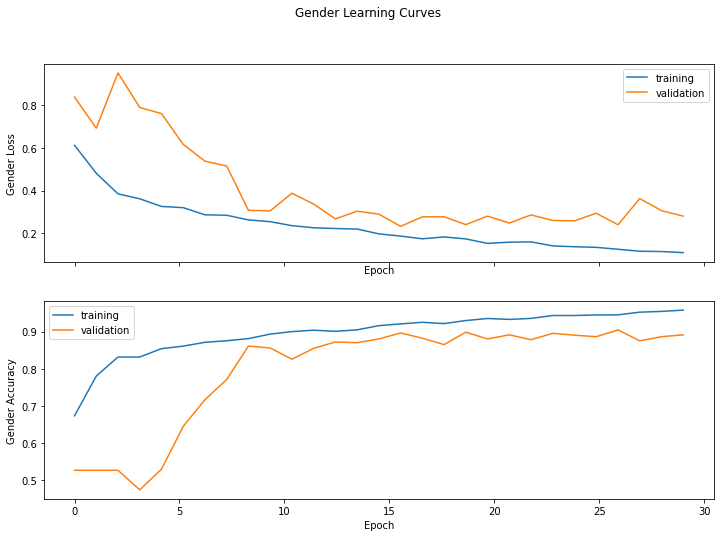

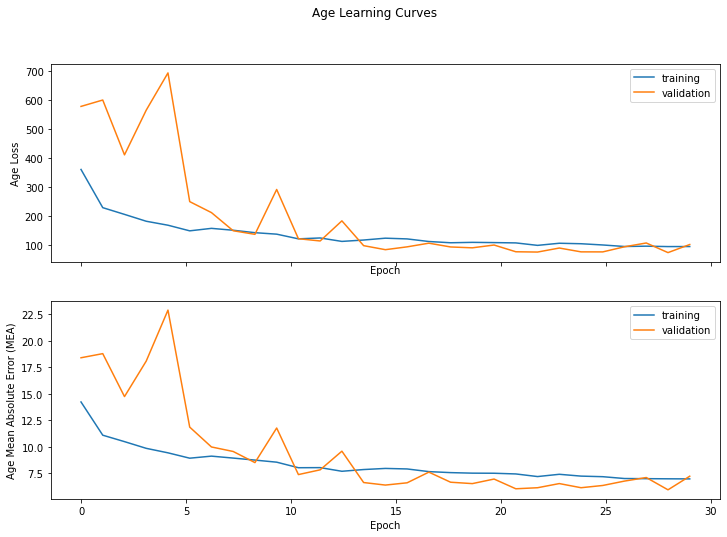

In [39]:
#
# Add your code here
#
early_stopped_epoch_count = early_stop_cb.stopped_epoch+1
epochs = np.linspace(0, early_stopped_epoch_count, early_stopped_epoch_count)

fig, (gender_loss, gender_accuracy) = plt.subplots(2, sharex=True)
fig.suptitle("Gender Learning Curves")
fig.set_size_inches(12,8)

gender_loss.set_xlabel("Epoch")
gender_loss.set_ylabel("Gender Loss")
gender_loss.plot(epochs, modelB_history.history['gender_output_loss'], label='training')
gender_loss.plot(epochs, modelB_history.history['val_gender_output_loss'], label='validation')
gender_loss.legend()

gender_accuracy.set_xlabel("Epoch")
gender_accuracy.set_ylabel("Gender Accuracy")
gender_accuracy.plot(epochs, modelB_history.history['gender_output_binary_accuracy'], label='training')
gender_accuracy.plot(epochs, modelB_history.history['val_gender_output_binary_accuracy'], label='validation')
gender_accuracy.legend()

plt.show()

fig, (age_loss, age_mae) = plt.subplots(2, sharex=True)
fig.suptitle("Age Learning Curves")
fig.set_size_inches(12,8)

age_loss.set_xlabel("Epoch")
age_loss.set_ylabel("Age Loss")
age_loss.plot(epochs, modelB_history.history['age_output_loss'], label='training')
age_loss.plot(epochs, modelB_history.history['val_age_output_loss'], label='validation')
age_loss.legend()

age_mae.set_xlabel("Epoch")
age_mae.set_ylabel("Age Mean Absolute Error (MEA)")
age_mae.plot(epochs, modelB_history.history['age_output_mean_absolute_error'], label='training')
age_mae.plot(epochs, modelB_history.history['val_age_output_mean_absolute_error'], label='validation')
age_mae.legend()

plt.show()

## STEP5: Evaluate the model on the test set
I will add my test code here to test the two models you trained. The test set will not be available before your submission. 

The metrics for measuring the performance on the test set are:
- age estimation: MAE (Mean Absolute Error)
- gender classification: accuracy


In [ ]:
#
# Don't add code in this cell when submitting this file
#